In [1]:
import numpy as np

from matplotlib import pyplot as plt

import gpflow

In [2]:
# original code
#  https://github.com/EmuKit/emukit/blob/main/emukit/test_functions/forrester.py


def forrester(x, sd=0):
    """
    Forrester function
    :param x: input vector to be evaluated
    :param sd: standard deviation of noise parameter
    :return: outputs of the function
    """
    x = x.reshape((len(x), 1))
    n = x.shape[0]
    fval = ((6 * x - 2) ** 2) * np.sin(12 * x - 4)
    if sd == 0:
        noise = np.zeros(n).reshape(n, 1)
    else:
        noise = np.random.normal(0, sd, n).reshape(n, 1)
    return fval.reshape(n, 1) + noise


def forrester_low(x, sd=0):
    """
    Low fidelity forrester function approximation:
    :param x: input vector to be evaluated
    :param sd: standard deviation of observation noise at low fidelity
    :return: outputs of the function
    """
    high_fidelity = forrester(x, 0)
    return (
        0.5 * high_fidelity
        + 10 * (x[:, [0]] - 0.5)
        + 5
        + np.random.randn(x.shape[0], 1) * sd
    )

In [3]:
import numpy as np

np.random.seed(42)

# Define high-fidelity and low-fidelity functions
high_fidelity = forrester
low_fidelity = forrester_low

# Generate plot inputs
x_plot = np.linspace(0, 1, 200)[:, None]

# Correct fidelity indicators (ensuring integer dtype)
X_L_plot = np.hstack([x_plot, np.zeros_like(x_plot, dtype=int)])  # LF test points
X_H_plot = np.hstack([x_plot, np.ones_like(x_plot, dtype=int)])   # HF test points

# Generate true function values for comparison
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

# Generate training data
x_train_l = np.atleast_2d(np.random.rand(40)).T
x_train_h = np.atleast_2d(np.random.permutation(x_train_l)[:13])

y_train_l = low_fidelity(x_train_l)
y_train_h = high_fidelity(x_train_h)

# Append integer fidelity indicators
X_L = np.hstack([x_train_l, np.zeros_like(x_train_l, dtype=int)])  # LF training
X_H = np.hstack([x_train_h, np.ones_like(x_train_h, dtype=int)])   # HF training

# Merge datasets
X = np.vstack([X_L, X_H])
Y = np.vstack([y_train_l, y_train_h])

# Debug: Print dataset info
print("\n🔍 Dataset Info:")
print(f"  X_L shape: {X_L.shape}, X_H shape: {X_H.shape}")
print(f"  X shape: {X.shape}, Y shape: {Y.shape}")
print(f"  X_L_plot shape: {X_L_plot.shape}, X_H_plot shape: {X_H_plot.shape}")
print(f"  First few X_L entries:\n{X_L[:5]}")
print(f"  First few X_H entries:\n{X_H[:5]}")


🔍 Dataset Info:
  X_L shape: (40, 2), X_H shape: (13, 2)
  X shape: (53, 2), Y shape: (53, 1)
  X_L_plot shape: (200, 2), X_H_plot shape: (200, 2)
  First few X_L entries:
[[0.87737307 0.        ]
 [0.74076862 0.        ]
 [0.69701574 0.        ]
 [0.70248408 0.        ]
 [0.35949115 0.        ]]
  First few X_H entries:
[[0.70248408 1.        ]
 [0.21582103 1.        ]
 [0.03050025 1.        ]
 [0.03594227 1.        ]
 [0.09398194 1.        ]]


In [4]:
X.shape, Y.shape

((53, 2), (53, 1))

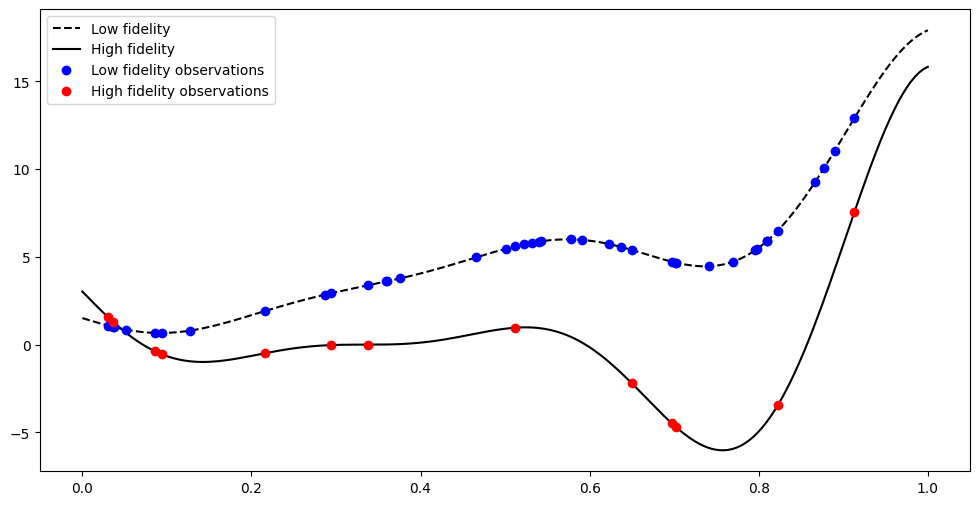

In [5]:
# plot the data
plt.figure(figsize=(12, 6))
plt.plot(x_plot, y_plot_l, "k--", label="Low fidelity")
plt.plot(x_plot, y_plot_h, "k", label="High fidelity")
plt.plot(x_train_l, y_train_l, "bo", label="Low fidelity observations")
plt.plot(x_train_h, y_train_h, "ro", label="High fidelity observations")
plt.legend()
plt.show()


## AR1 Model in GPFlow

In [6]:
# include the import path from previous directory
import sys
sys.path.append("/Users/jibanmac/Documents/GitHub/multi_fidelity_gpflow/")

In [7]:
from mfgpflow.linear import MultiFidelityGPModel

# Define kernels
kernel_L = gpflow.kernels.SquaredExponential()
kernel_delta = gpflow.kernels.SquaredExponential()


In [8]:
# Train multi-fidelity GP
mf_gp = MultiFidelityGPModel(X, Y, kernel_L, kernel_delta)

# First pass: Optimize with noise fixed, then unfix after 500 steps
mf_gp.optimize(max_iters=1000, learning_rate=0.01, use_adam=False, unfix_noise_after=500)

# Print final learned noise variance
print("Learned noise variance:", mf_gp.likelihood.variance.numpy())

Optimizing with L-BFGS (Scipy)...


2025-01-29 22:51:37.632260: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Learned noise variance: 1e-06


In [9]:
print("Final learned rho values:", mf_gp.kernel.rho.numpy())

Final learned rho values: [[1.99976991]]



🔍 Checking Fidelity Values in Training Set (X):
  Unique values in Training Set (X)[:, -1]: [0. 1.]
  Shape: (53, 2)
  First few entries:
[[0.87737307 0.        ]
 [0.74076862 0.        ]
 [0.69701574 0.        ]
 [0.70248408 0.        ]
 [0.35949115 0.        ]]

🔍 Checking Fidelity Values in X_L_plot (Low-Fidelity Test):
  Unique values in X_L_plot (Low-Fidelity Test)[:, -1]: [0.]
  Shape: (200, 2)
  First few entries:
[[0.         0.        ]
 [0.00502513 0.        ]
 [0.01005025 0.        ]
 [0.01507538 0.        ]
 [0.0201005  0.        ]]

🔍 Checking Fidelity Values in X_H_plot (High-Fidelity Test):
  Unique values in X_H_plot (High-Fidelity Test)[:, -1]: [1.]
  Shape: (200, 2)
  First few entries:
[[0.         1.        ]
 [0.00502513 1.        ]
 [0.01005025 1.        ]
 [0.01507538 1.        ]
 [0.0201005  1.        ]]
Testing K(X_L_plot, X) shape: (213, 53)
Testing K(X_H_plot, X) shape: (213, 53)

🔍 Running GP Predictions...

🔍 Prediction Debug Info:
  mean_LF shape: (213, 1

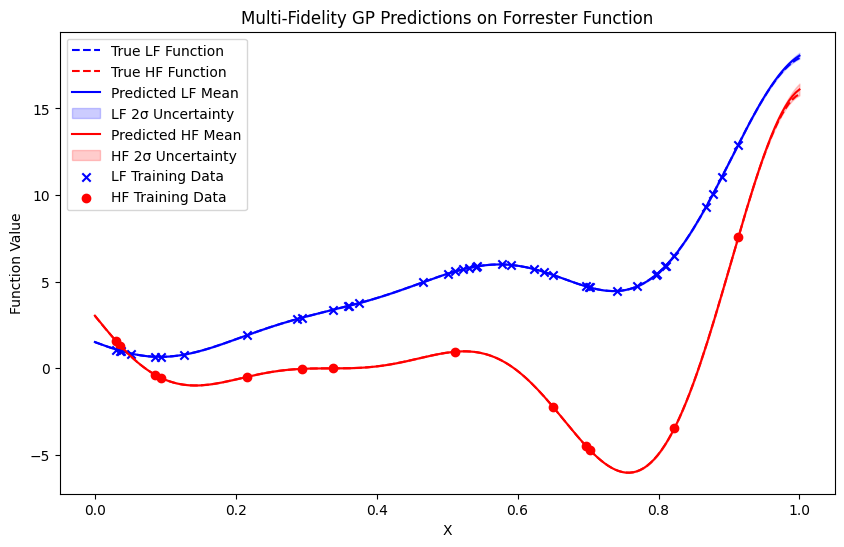

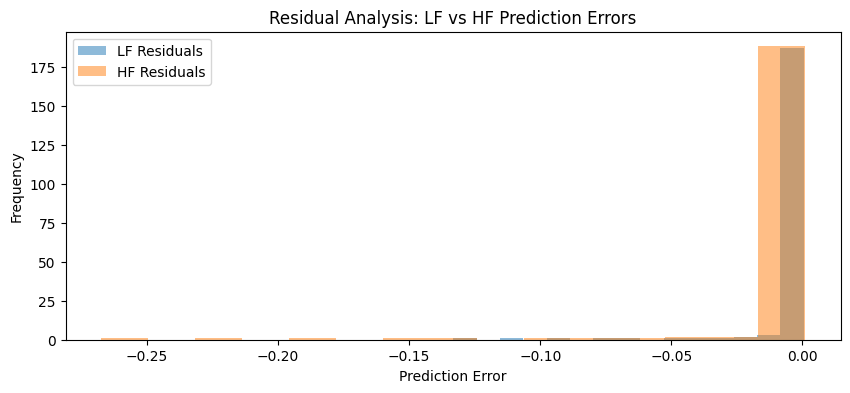


🔍 Final learned rho values:
[[1.99976991]]


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 🔹 1️⃣ Ensure Fidelity Indicators Are Correct
def check_fidelity_values(X, name):
    """ Prints unique fidelity values to confirm proper dataset formatting. """
    print(f"\n🔍 Checking Fidelity Values in {name}:")
    print(f"  Unique values in {name}[:, -1]: {np.unique(X[:, -1])}")
    print(f"  Shape: {X.shape}")
    print(f"  First few entries:\n{X[:5]}")

# 🔹 2️⃣ Ensure Model Can Evaluate Covariance
def check_kernel_evaluation():
    """ Checks if the kernel can compute covariance correctly. """
    try:
        print("Testing K(X_L_plot, X) shape:", mf_gp.kernel.K(np.vstack([X_L_plot, X_H]), X).shape)
        print("Testing K(X_H_plot, X) shape:", mf_gp.kernel.K(np.vstack([X_H_plot, X_H]), X).shape)
    except Exception as e:
        print("❌ Kernel evaluation failed:", e)

# ✅ Ensure Fidelity Indicators Are Properly Set
check_fidelity_values(X, "Training Set (X)")
check_fidelity_values(X_L_plot, "X_L_plot (Low-Fidelity Test)")
check_fidelity_values(X_H_plot, "X_H_plot (High-Fidelity Test)")

# ✅ Ensure Model Can Evaluate Kernel
check_kernel_evaluation()

# 🔹 3️⃣ Predict at New Test Points (Including HF Training Points)
print("\n🔍 Running GP Predictions...")
mean_LF, var_LF = mf_gp.predict_f(np.vstack([X_L_plot, X_H]))  # Ensure HF points are included
mean_HF, var_HF = mf_gp.predict_f(np.vstack([X_H_plot, X_H]))  # Ensure HF points are included

# ✅ Debug Prediction Outputs
print("\n🔍 Prediction Debug Info:")
print(f"  mean_LF shape: {mean_LF.shape}, var_LF shape: {var_LF.shape}")
print(f"  mean_HF shape: {mean_HF.shape}, var_HF shape: {var_HF.shape}")

# 🔹 4️⃣ Plot Multi-Fidelity GP Predictions
plt.figure(figsize=(10, 6))

# Plot True Functions
plt.plot(x_plot, y_plot_l, 'b--', label="True LF Function")
plt.plot(x_plot, y_plot_h, 'r--', label="True HF Function")

# Plot GP Predictions
plt.plot(x_plot, mean_LF[:200], 'b-', label="Predicted LF Mean")  # First 200 are LF test points
plt.fill_between(
    x_plot.flatten(), 
    (mean_LF[:200] - 2 * np.sqrt(var_LF[:200])).numpy().flatten(), 
    (mean_LF[:200] + 2 * np.sqrt(var_LF[:200])).numpy().flatten(), 
    color='b', alpha=0.2, label="LF 2σ Uncertainty"
)
plt.plot(x_plot, mean_HF[:200], 'r-', label="Predicted HF Mean")  # First 200 are HF test points
plt.fill_between(
    x_plot.flatten(), 
    (mean_HF[:200] - 2 * np.sqrt(var_HF[:200])).numpy().flatten(), 
    (mean_HF[:200] + 2 * np.sqrt(var_HF[:200])).numpy().flatten(), 
    color='r', alpha=0.2, label="HF 2σ Uncertainty"
)

# Overlay Training Data
plt.scatter(X[:, 0][X[:, -1] == 0], Y[X[:, -1] == 0], color='b', marker='x', label="LF Training Data")
plt.scatter(X[:, 0][X[:, -1] == 1], Y[X[:, -1] == 1], color='r', marker='o', label="HF Training Data")

plt.xlabel("X")
plt.ylabel("Function Value")
plt.legend()
plt.title("Multi-Fidelity GP Predictions on Forrester Function")
plt.show()

# 🔹 5️⃣ Residual Analysis (Error Between True and Predicted)
residuals_LF = y_plot_l - mean_LF[:200].numpy()
residuals_HF = y_plot_h - mean_HF[:200].numpy()

plt.figure(figsize=(10, 4))
plt.hist(residuals_LF, bins=15, alpha=0.5, label="LF Residuals")
plt.hist(residuals_HF, bins=15, alpha=0.5, label="HF Residuals")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Residual Analysis: LF vs HF Prediction Errors")
plt.show()

# 🔹 6️⃣ Check Learned `rho` Values
print("\n🔍 Final learned rho values:")
print(mf_gp.kernel.rho.numpy())